In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
import deeptriplet
import deeptriplet.datasets

In [12]:
d = deeptriplet.datasets.PascalDataset(
                        pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt")

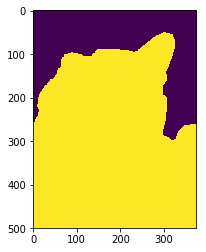

In [16]:
t = d[18][1]
t[t == 255] = 0
plt.imshow(t)

In [50]:
trainset = PascalDatasetRandomTripletAugmented(
                        pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        n_triplets=1500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


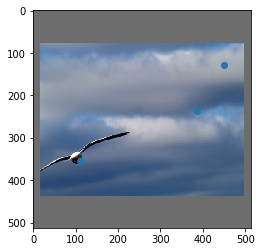

In [60]:
t = trainset[111]
p = t[1].numpy()
plt.imshow(np.transpose(t[0], axes=(1,2,0)) / 4 + 0.43)
plt.scatter([p[0][1][0], p[1][1][0], p[2][1][0]],
           [p[0][0][0], p[1][0][0], p[2][0][0]])

In [49]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageOps, ImageFilter
import math
import random

from torch.utils import data
from torchvision import transforms

def read_labeled_image_list(data_dir, data_list):
    """Reads txt file containing paths to images and ground truth masks.

    Args:
      data_dir: path to the directory with images and masks.
      data_list: path to the file with lines of the form '/path/to/image /path/to/mask'.

    Returns:
      Two lists with all file names for images and masks, respectively.
    """
    f = open(data_list, 'r')
    images = []
    masks = []
    for line in f:
        image, mask = line.strip("\n").split(' ')
        images.append(data_dir + image)
        masks.append(data_dir + mask)

    return images, masks

class PascalDatasetRandomTripletAugmented(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.
    """

    def __init__(
            self,
            *,
            pascal_root,
            split_file,
            n_triplets,
    ):
        self.split_file = split_file
        self.pascal_root = pascal_root
        self.n_triplets = n_triplets

        self.n_classes = 21
        
        self.crop_size = 513
        self.base_size = 513

        self.image_list, self.label_list = read_labeled_image_list(self.pascal_root, self.split_file)

        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])
        
        self.fill_image = (124, 116, 104)
        self.fill_label = 255


    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):
        im_path = self.image_list[index]
        lbl_path = self.label_list[index]

        img = PIL.Image.open(im_path)
        lbl = PIL.Image.open(lbl_path)

        ## augmentation
        img, lbl = self._augment(img, lbl)

        img, lbl, minrange, maxrange = self._random_crop(img, lbl)
        
        img = np.array(img, dtype=np.float32) / 255.0
        lbl = np.array(lbl, dtype=np.long)
        #         lbl[lbl==255] = 0

        img = self.transforms(img)
        
        minrange = [0, 0]
        maxrange = [513, 513]
        
        triplets = self._generate_triplet(lbl, minrange, maxrange)
        

        return img, triplets
    
    
    def _augment(self, img, lbl):
        
        if np.random.rand() > 0.5:
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            lbl = lbl.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
        if np.random.random() < 0.5:
            img = img.filter(PIL.ImageFilter.GaussianBlur(
                radius=random.random()))

        
        
        return img, lbl

    
    def _random_crop(self, img, mask):
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        padh = self.crop_size - oh if oh < self.crop_size else 0
        padw = self.crop_size - ow if ow < self.crop_size else 0
        if short_size < self.crop_size:
            img = ImageOps.expand(img, border=(padw//2 + 1, padh//2 + 1, padw//2 + 1, padh//2 + 1), fill=self.fill_image)
            mask = ImageOps.expand(mask, border=(padw//2 + 1, padh//2 + 1, padw//2 + 1, padh//2 + 1), fill=self.fill_label)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - self.crop_size)
        y1 = random.randint(0, h - self.crop_size)
        img = img.crop((x1, y1, x1 + self.crop_size, y1 + self.crop_size))
        mask = mask.crop((x1, y1, x1 + self.crop_size, y1 + self.crop_size))

        ## TODO: unnecessary code
        minrange = [max(x1 - padw//2 - 1, 0), max(y1 - padh//2 - 1, 0)]
        maxrange = [min(x1 + 2 * self.crop_size - padw//2 - 1 - w, self.crop_size - 1), 
                    min(y1 + 2 * self.crop_size - padh//2 - 1 - h, self.crop_size - 1)]
        
        return img, mask, minrange, maxrange
    

    def _generate_triplet(self, lbl, minrange, maxrange):
        lbl_view = lbl[minrange[0]:maxrange[0], minrange[1]:maxrange[1]]
        
        options = np.nonzero(lbl_view.reshape(-1) != 255)[0]
        
        if options.shape[0] > 0:
            ai = np.random.randint(low=0, 
                                    high=options.shape[0], 
                                    size=(self.n_triplets,))
            ai = options[ai]
        else:
            ai = np.array([0] * self.n_triplets, dtype=np.int64)
        

        classes, inv_map = np.unique(lbl_view, return_inverse=True)
        n_classes = len(classes)
        inv_map = inv_map.reshape(lbl_view.shape[0], lbl_view.shape[1])
        inv_map_flat = inv_map.reshape(-1)

        class_lookup = (np.arange(n_classes, dtype=np.int32).reshape((1, 1, n_classes)) !=
                        inv_map.reshape(lbl_view.shape[0], lbl_view.shape[1], 1))
        class_lookup = np.transpose(class_lookup, axes=[2, 0, 1])
        
        lbl_view_flat = lbl_view.reshape(-1)
        
        lneg = []
        lpos = []
        for i in range(n_classes):
            lneg.append(np.transpose(np.logical_and(lbl_view != 255, class_lookup[i]).reshape(-1).nonzero()).reshape((-1)))
            lpos.append(np.transpose(
                                np.logical_and(lbl_view != 255, 
                                               np.logical_not(class_lookup[i])).reshape(-1).nonzero()).reshape((-1)))

        ni, pi = [], []
        for i in range(self.n_triplets):
            cni = lneg[inv_map_flat[ai[i]]]
            cpi = lpos[inv_map_flat[ai[i]]]
            if len(cni) == 0 or len(cpi) == 0:
                ni.append(ai[i])
                pi.append(ai[i])
            else:
                ni.append( np.random.choice(cni))
                pi.append( np.random.choice(cpi))
            
        aix, aiy = np.unravel_index(ai, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        aix += minrange[0]
        aiy += minrange[1]
        ai = np.stack((aix, aiy))
        
        pix, piy = np.unravel_index(pi, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        pix += minrange[0]
        piy += minrange[1]
        pi = np.stack((pix, piy))
        
        nix, niy = np.unravel_index(ni, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        nix += minrange[0]
        niy += minrange[1]
        ni = np.stack((nix, niy))
        
        triplets = np.stack((ai, pi, ni), axis=0)
        triplets = torch.tensor(triplets, dtype=torch.long)
    
        return triplets
    


    

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb
